In [5]:
# !pip install langchain_openai

In [6]:
# from langchain_openai import ChatOpenAI
# from langchain.llms import Ollama
# import time

# judge_llm = ChatOpenAI(
#     api_key="none",
#     base_url='http://127.0.0.1:11434/v1',
#     model='qwen2:7b-instruct',
#     temperature=0
# )
# judge_llm.invoke('你是谁？')

In [7]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=替换为自己的key

env: LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
env: LLM_API_KEY=替换为自己的key


In [8]:
# %%capture --no-stderr
# !pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil

In [9]:
# import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

# for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
#     print(f"{module.__name__:<30}{module.__version__}")

In [10]:
# !pip list|grep langchain-openai

In [11]:
import os
import pandas as pd

from langchain_community.vectorstores import Chroma

In [12]:
expr_version = 'retrieval_bge_ft'

preprocess_output_dir = r""
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 文档处理

## 文档加载

In [13]:
from langchain_community.document_loaders import PyPDFLoader

In [14]:
loader = PyPDFLoader(os.path.join(os.path.pardir, 'data_test', 'GeoChat.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

d:\Anaconda\envs\gold-yolo\lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


## 文档切分

In [15]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [16]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


## 向量化

In [17]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='Generate a representation for this sentence to retrieve related articles：'
    )
    return embeddings

device: cuda


In [18]:
from tqdm.auto import tqdm
import shutil

vector_db_dict = {}

emb_names = [
    'bge_large',
    'bge_large_finetune'
]
model_paths = [
    # 如果已经下载到本地，可以替换为本地路径
    'BAAI/bge-large-en-v1.5',
    r''
]

for name, model_path in tqdm(zip(emb_names, model_paths), total=len(emb_names)):
    # 确保结果可复现性
    persist_directory = os.path.join(expr_dir, 'chroma', name)
    shutil.rmtree(persist_directory, ignore_errors=True)
    
    embeddings = get_embeddings(model_path)
    vector_db_dict[name] = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )

d:\Anaconda\envs\gold-yolo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 50%|█████     | 1/2 [00:18<00:18, 18.56s/it]You try to use a model that was created with version 3.1.1, however, your version is 3.1.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



100%|██████████| 2/2 [00:22<00:00, 11.16s/it]


In [19]:
vector_db_dict

{'bge_large': <langchain_community.vectorstores.chroma.Chroma at 0x1f779d5f580>,
 'bge_large_finetune': <langchain_community.vectorstores.chroma.Chroma at 0x1f78aedeee0>}

# 检索

In [20]:
def retrieve(vector_db, query: str, k=5):
    return vector_db.similarity_search(query, k=k)

## 计算检索准确率

In [21]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [22]:
def get_hit_stat_df(vector_db, top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        retriever = vector_db.as_retriever(search_kwargs={'k': k})
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve(vector_db, question, k=k)
            chunks = retriever.get_relevant_documents(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [23]:
hit_stat_dfs = []
for key in vector_db_dict:
    vector_db = vector_db_dict[key]
    hit_stat_df = get_hit_stat_df(vector_db)
    hit_stat_df['emb_model'] = key
    hit_stat_dfs.append(hit_stat_df)

  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp\ipykernel_13932\2013367818.py:10: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  chunks = retriever.get_relevant_documents(question)[:k]
100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


In [24]:
hit_stat_dfs

[                                              question  top_k  hit  \
 0    What is proposed to address the limitations me...      1    0   
 1    What is one of the types of data used in the n...      1    0   
 2    What kind of data is mentioned as being abunda...      1    0   
 3    What does GeoChat require to generate visually...      1    0   
 4        What types of responses can GeoChat generate?      1    0   
 ..                                                 ...    ...  ...   
 795  Which journal published the paper 'transformer...      8    1   
 796  What is the focus of the research described in...      8    0   
 797  Who are the authors of the work published in T...      8    1   
 798  On what pages was the paper about land-use cla...      8    1   
 799  What topic does the paper by Zhenghang Yuan, L...      8    1   
 
      retrieved_chunks  emb_model  
 0                   1  bge_large  
 1                   1  bge_large  
 2                   1  bge_large  
 3

In [25]:
all_hit_stat_df = pd.concat(hit_stat_dfs)

这个结果，与baseline中的结果，是不一样的

In [26]:
all_hit_stat_df.groupby(['emb_model', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,emb_model,top_k,hit_rate
0,bge_large,1,0.31
1,bge_large,2,0.49
2,bge_large,3,0.56
3,bge_large,4,0.58
4,bge_large,5,0.65
5,bge_large,6,0.65
6,bge_large,7,0.67
7,bge_large,8,0.67
8,bge_large_finetune,1,0.41
9,bge_large_finetune,2,0.50


<Axes: xlabel='top_k', ylabel='hit'>

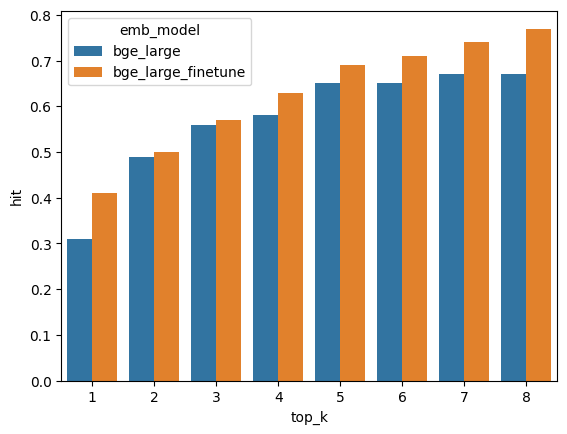

In [27]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='emb_model', data=all_hit_stat_df, errorbar=None)

# 问答全流程

In [28]:
from langchain.llms import Ollama

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [29]:
# llm.invoke('你是谁')

In [30]:
def rag(vector_db, query, n_chunks=4):
    prompt_tmpl = """
You are a remote sensing expert who is good at analyzing and reasoning about problems based on the information fragments obtained.
Your task is to answer questions based on the information fragments obtained (the content between <<<<context>>><<<</context>>>).
Keep your answers concise, do not repeat the question, do not add descriptive explanations and anything irrelevant to the answer.
Known information:
<<<<context>>>
{{knowledge}}
<<<</context>>>

Question: {{query}}
Please answer:
""".strip()

    chunks = retrieve(vector_db, query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm(prompt), chunks

In [31]:
# print(rag(vector_db_dict['bge_large'], 'What type of model is GeoChat?')[0])

In [32]:
# print(rag(vector_db_dict['bge_large_finetune'], 'What type of model is GeoChat?')[0])

## 预测

In [33]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, vector_db, n_chunks):
    prediction_df = prediction_df.copy()

    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

检索片段数为4的

In [34]:
bge_vanilla_4_pred_df = predict(prediction_df, vector_db_dict['bge_large'], n_chunks=4)
bge_ft_4_pred_df = predict(prediction_df, vector_db_dict['bge_large_finetune'], n_chunks=4)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp\ipykernel_13932\1226247225.py:18: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  return llm(prompt), chunks
100%|██████████| 100/100 [14:02<00:00,  8.42s/it]


检索片段数为1的

In [35]:
bge_vanilla_pred_df = predict(prediction_df, vector_db_dict['bge_large'], n_chunks=1)
bge_ft_pred_df = predict(prediction_df, vector_db_dict['bge_large_finetune'], n_chunks=1)

100%|██████████| 100/100 [11:32<00:00,  6.92s/it]


# 评估

In [39]:
# from langchain_openai import ChatOpenAI
from langchain.llms import Ollama
import time

# judge_llm = ChatOpenAI(
#     api_key="none",
#     base_url='http://127.0.0.1:11434/v1',
#     model_name='qwen2-72b-instruct',
#     temperature=0
# )  # 输出是字典，内容要.content获取
judge_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)   # 输出是str

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
You are a remote sensing expert. Now I have a series of questions. An assistant has already answered these questions. You need to refer to the reference answer and evaluate whether the assistant's answer is correct. Just reply "yes" or "no" without other descriptive content or irrelevant information.
Question:
<question>
{{question}}
</question>

Reference answer:
<ref_answer>
{{ref_answer}}
</ref_answer>

Assistant answer:
<gen_answer>
{{gen_answer}}
</gen_answer>
Please evaluate:
"""
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt)
        results.append(result)

        time.sleep(1)
    return results

## 知识片段数为1

In [40]:
bge_vanilla_pred_df['raw_score'] = evaluate(bge_vanilla_pred_df)
bge_ft_pred_df['raw_score'] = evaluate(bge_ft_pred_df)

100%|██████████| 100/100 [06:07<00:00,  3.67s/it]


In [41]:
bge_vanilla_pred_df['raw_score'].unique(), bge_ft_pred_df['raw_score'].unique()

(array(['No', 'no', 'yes', 'Yes'], dtype=object),
 array(['No', 'no', 'yes', 'Yes'], dtype=object))

In [42]:
bge_vanilla_pred_df['score'] = (bge_vanilla_pred_df['raw_score'] == 'yes').astype(int) + (bge_vanilla_pred_df['raw_score'] == 'Yes').astype(int)
bge_ft_pred_df['score'] = (bge_ft_pred_df['raw_score'] == 'yes').astype(int) + (bge_ft_pred_df['raw_score'] == 'Yes').astype(int)

In [43]:
bge_vanilla_pred_df['score'].mean(), bge_ft_pred_df['score'].mean()

(0.48, 0.54)

准确率

In [44]:
bge_vanilla_pred_df[bge_vanilla_pred_df['qa_type'] == 'detailed']['score'].mean(), bge_ft_pred_df[bge_ft_pred_df['qa_type'] == 'detailed']['score'].mean()

(0.48, 0.54)

In [45]:
bge_vanilla_pred_df['retrieval_hit'] = bge_vanilla_pred_df.apply(lambda row: int(row['uuid'] in [doc.metadata['uuid'] for doc in row['chunks']]), axis=1)
bge_ft_pred_df['retrieval_hit'] = bge_ft_pred_df.apply(lambda row: int(row['uuid'] in [doc.metadata['uuid'] for doc in row['chunks']]), axis=1)

In [49]:
bge_vanilla_pred_df['retrieval_hit'].mean()

0.31

## 知识片段数为4

In [50]:
bge_vanilla_4_pred_df['raw_score'] = evaluate(bge_vanilla_4_pred_df)
bge_ft_4_pred_df['raw_score'] = evaluate(bge_ft_4_pred_df)

100%|██████████| 100/100 [06:04<00:00,  3.65s/it]


In [51]:
bge_vanilla_4_pred_df['raw_score'].unique(), bge_ft_4_pred_df['raw_score'].unique()

(array(['no', 'yes', 'Yes', 'No'], dtype=object),
 array(['no', 'yes', 'No', 'Yes'], dtype=object))

In [52]:
bge_vanilla_4_pred_df['score'] = (bge_vanilla_4_pred_df['raw_score'] == 'yes').astype(int) + (bge_vanilla_4_pred_df['raw_score'] == 'Yes').astype(int)
bge_ft_4_pred_df['score'] = (bge_ft_4_pred_df['raw_score'] == 'yes').astype(int) + (bge_ft_4_pred_df['raw_score'] == 'Yes').astype(int)

In [58]:
bge_vanilla_4_pred_df['score'].mean(), bge_ft_4_pred_df['score'].mean()

(0.7, 0.68)

: 

In [53]:
bge_ft_4_pred_df

,uuid,question,qa_type,ref_answer,gen_answer,chunks,raw_score,score
11,37163d64-7378-4168-9998-b89240a20c84,What is proposed to address the limitations me...,detailed,"GeoChat, the first versatile remote sensing VL...",A multi-layer perceptron (MLP) is used for ada...,[page_content='bels. Table 4 presents various ...,no,0
24,8d02ff70-fd24-4093-89d1-307e84228ab3,What is one of the types of data used in the n...,detailed,Aligned image-text data sourced from web imagery.,Referring expression datasets are available in...,"[page_content='tributes {a2, a3}can be arrange...",yes,1
26,8d02ff70-fd24-4093-89d1-307e84228ab3,What kind of data is mentioned as being abunda...,detailed,Aligned image-text data.,Referring expression datasets,"[page_content='tributes {a2, a3}can be arrange...",no,0
31,33890465-ae6c-42b4-85cf-b5d2e06849fc,What does GeoChat require to generate visually...,detailed,GeoChat requires suitable task tokens and user...,GeoChat requires suitable task tokens and user...,"[page_content='ther, RSGPT cannot work for reg...",yes,1
32,33890465-ae6c-42b4-85cf-b5d2e06849fc,What types of responses can GeoChat generate?,detailed,GeoChat can generate visually grounded respons...,"GeoChat can generate textual responses, only v...",[page_content='Figure 5. Qualitative results o...,No,0
...,...,...,...,...,...,...,...,...
582,2bd164ad-af46-4f8c-b077-f21b75d1bc59,Which journal published the paper 'transformer...,detailed,IEEE Transactions on Geoscience and Remote Sen...,IEEE Transactions on Geoscience and Remote Sen...,[page_content='transformer toward remote sensi...,yes,1
588,3556a521-8749-4771-96b3-fe1f968c2d6b,What is the focus of the research described in...,detailed,The research focuses on scene classification.,The focus of the research is exploring data an...,[page_content='IEEE Transactions on Geoscience...,no,0
591,7c42c969-4b9b-4d90-9428-492913954435,Who are the authors of the work published in T...,detailed,"Peter Young, Alice Lai, Micah Hodosh, and Juli...","Peter Young, Alice Lai, Micah Hodosh, and Juli...","[page_content='Linguistics , 2:67–78, 2014. 7\...",yes,1
596,7c42c969-4b9b-4d90-9428-492913954435,On what pages was the paper about land-use cla...,detailed,pages 270–279,Pages 270–279,[page_content='tial extensions for land-use cl...,Yes,1
